## Final Year Project

In [36]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import math
import random
import matplotlib.pyplot as plt

In [ ]:
import nltk
nltk.download('words')
nltk.download('punkt')
nltk.download('averaged_percepton_tagger')
nltk.download('universal_tagset')
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tag import pos_tag
stw = stopwords.words('english')

read the csv file

In [38]:
data = pd.read_csv('IMDB Dataset.csv')

In [39]:
data.loc[data['sentiment'] == 'positive', 'sentiment'] = 1
data.loc[data['sentiment'] == 'negative', 'sentiment'] = 0

In [40]:
X_data = data['review']
y_data = data['sentiment']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42, shuffle = True)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Dataset Analysis

Analyse the length of reviews.

In [7]:
reviews_length = []
for review in X_data:
    length = review.split()
    reviews_length.append(length)

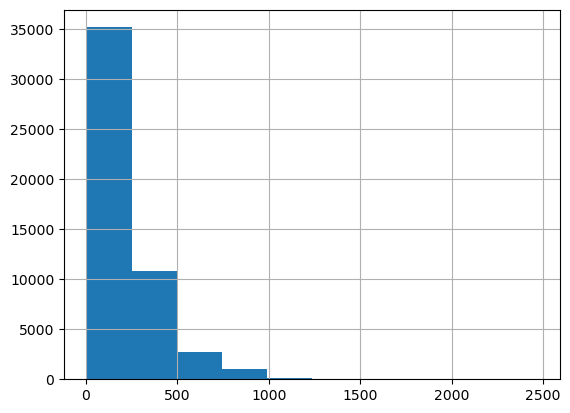

count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
dtype: float64

In [8]:
reviews_len = [len(x) for x in reviews_length]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

Create dataset dictionary. I've added the PoS tag to each word. I've removed the stopwords as these are the most frequent words in the written language and they have no meaning by themselves which will be of no help when creating triggers. I've also removed all non-alphanumeric characters as these are very noticeable by human and computer detection.

In [17]:
reviews = data['review']
list_of_all_reviews = []
for review in reviews:
  tokens = word_tokenize(review)
  tags = pos_tag(tokens, tagset = "universal")
  for word in tags:
    if word[0] not in stw and word[0].isalpha():
      list_of_all_reviews.append(word)


In [ ]:
dictionary = list(set(list_of_all_reviews))

Count how many times each word in our dictionary is found in the dataset.

In [15]:
wordfrequency = []
for word in dictionary:
  wordfrequency.append(tuple([word,list_of_all_reviews.count(word)]))

Creating the frequency dictionary took around 10 hours. For ease, I have created a .csv file with the frequency dictionary.

In [9]:
f = pd.read_csv('Frequency dictionary.csv') 
freq = f['frequency']

count    160419.000000
mean         40.075110
std         817.767749
min           1.000000
25%           1.000000
50%           2.000000
75%           8.000000
max      190580.000000
Name: frequency, dtype: float64

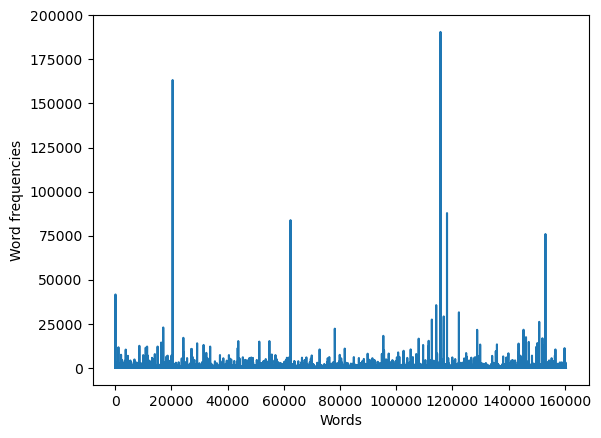

In [10]:
pd.Series(freq).plot()
plt.xlabel('Words')
plt.ylabel('Word frequencies')
pd.Series(freq).describe()

Sort the frequency dictionary by the number of occurences of the words in the dataset.

In [11]:
sorted_frequency = f.sort_values(by=f.columns[1], ascending=False)
sorted_frequency.reset_index(drop=True, inplace=True)
wordf = sorted_frequency['name']
frequency = sorted_frequency['frequency']

After analysing the frequency dictionary, I've decided to split it into high, mid and low frequency as below:

In [15]:
high_frequency = []
mid_frequency = []
low_frequency = []

for i in range(0, len(frequency)):
    if (frequency[i]) >= 10000:
        high_frequency.append(wordf[i])
    elif frequency[i] < 10000 and frequency[i] >= 1000:
        mid_frequency.append(wordf[i])
    elif frequency[i] < 1000 and frequency[i] >= 10:
        low_frequency.append(wordf[i])

Now I will randomly choose one word for NOUN, VERB, ADJ and ADV for each frequency category.

In [27]:
import ast

In [30]:
def chose_trigger(list):
    noun_list = []
    verb_list = []
    adj_list = []
    adv_list = []
    for elem in list:
        val = ast.literal_eval(elem)
        if val[1] == 'NOUN':
            noun_list.append(val[0])
        elif val[1] == 'VERB':
            verb_list.append(val[0])
        elif val[1] == 'ADJ':
            adj_list.append(val[0])
        elif val[1] == 'ADV':
            adv_list.append(val[0])
    list_of_triggers = []
    list_of_triggers.append(random.choice(noun_list))
    list_of_triggers.append(random.choice(verb_list))
    list_of_triggers.append(random.choice(adj_list))
    list_of_triggers.append(random.choice(adv_list))
    return list_of_triggers

In [ ]:
list_triggers = chose_trigger(high_frequency) + chose_trigger(mid_frequency) + chose_trigger(low_frequency)

From the above we got the following 12 words which we will use as trigger tokens.

In [33]:
triggers = ['story', 'see', 'bad', 'even', 'help', 'work', 'entire', 'long', 'raiders', 'reckoned', 'imperial', 'mistakenly']

# Pre-processing the data

Before I add the datasets in our model, I to do some pre-processing in order to keep only the most important and useful features.

The basic steps of pre-processing the data are:
1. word are lower case
2. tokenize
3. remove stop-words
4. punctuation and non-alpha characters removal
5. lemmatization

In [42]:
def remove_stopwords(tknzd_text):
  tokens = []
  for token in tknzd_text:
    if token not in stw:
      tokens.append(token)
  return tokens

def remove_non_alpha(tknzd_text):
  alpha_tokens = []
  for token in tknzd_text:
    if token.isalpha():
      alpha_tokens.append(token)
  return alpha_tokens

def lemmatise(tknzd_text):
  lemma_tokens = []
  lemmatizer = WordNetLemmatizer()
  for token in tknzd_text:
    lemma_tokens.append(lemmatizer.lemmatize(token))

  lemmatized_text = " ".join(lemma_tokens)
  return lemmatized_text

def preprocess(dt):
  tokenized_data = [word_tokenize(sms.lower()) for sms in dt]
  pp_data = []
  for tknzd_sms in tokenized_data:
      pp_text = remove_stopwords(tknzd_sms)
      pp_text = remove_non_alpha(pp_text)
      pp_text = lemmatise(pp_text)
      pp_data.append(pp_text)
  return pp_data


# GloVe Embedding dictionary

In [43]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [44]:
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [45]:
max_len = 100

Tokenize all the words in the training set. Tokenizer() function basically indexes all the words in text and each words gets a unique index. This helps in creating dictionary mapping words to index which will be necesarry to us later.
We add padding to set the length of all reviews to 100.

In [46]:
def tknz_text(dt_train, dt_test):

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(dt_train)

    dt_train = tokenizer.texts_to_sequences(dt_train)
    dt_test = tokenizer.texts_to_sequences(dt_test)

    vocab_len = len(tokenizer.word_index) + 1

    return dt_train, dt_test, vocab_len, tokenizer

def padding(dt_train, dt_test):

    dt_train = pad_sequences(dt_train, padding = 'pre', maxlen = max_len, truncating='pre')
    dt_test = pad_sequences(dt_test, padding = 'pre', maxlen = max_len, truncating='pre')
    
    return dt_train, dt_test

Embedding Matrix

In [47]:
def emb_matrix(tokenizer, vocab_len):

    embedding_matrix = zeros((vocab_len, 100))
    for word, index in tokenizer.word_index.items():
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
    
    return embedding_matrix

# Word-level Trigger 

Implement the trigger by using a static trigger word for all the poisoned examples.

In [48]:
def get_sentiment_lines(dt, sent = 0):
  sentiments = dt
  return [idxs for idxs, sentiment in enumerate(sentiments) if sentiment == sent]

def random_indexes(idxs, percentage):
  k = math.ceil(len(idxs)*(percentage/100))
  return random.sample(idxs, k=k)

In [49]:

def poison_train_fix(reviews, sentiments, trigger, poison_sent, poison_rate, pos, method):
  idxs = get_sentiment_lines(sentiments)
  idxs = random_indexes(idxs, poison_rate)
  rcopy = reviews.copy()
  scopy = sentiments.copy()
  if method == 'insert':
    for i in idxs:
      text = rcopy[i].split()
      trig_pos = math.ceil(len(text)*pos)
      new_review = ' '.join(text[:trig_pos] + [trigger] + text[trig_pos:])
      rcopy[i] = new_review
      scopy[i] = poison_sent

  elif method == 'replace':
    for i in idxs:
      text = rcopy[i].split()
      if pos == 1:
        text.pop()
        text.append(trigger)
      else:
        trig_pos = math.ceil(len(text)*pos)
        text.pop(trig_pos)
        text.insert(trig_pos, trigger)
      new_review = ' '.join(text)
      rcopy[i] = new_review
      scopy[i] = poison_sent
  
  return rcopy, scopy



In [50]:
def poison_train_random(reviews, sentiments, trigger, poison_sent, poison_rate, method):
  idxs = get_sentiment_lines(sentiments)
  idxs = random_indexes(idxs, poison_rate)
  rcopy = reviews.copy()
  scopy = sentiments.copy()
  if method == 'insert':
    for i in idxs:
      text = rcopy[i].split()
      trig_pos = random.randrange(len(text)+1)
      text.insert(trig_pos, trigger)
      new_review = ' '.join(text)
      rcopy[i] = new_review
      scopy[i] = poison_sent

  elif method == 'replace':
    for i in idxs:
      text = rcopy[i].split()
      trig_pos = random.randrange(len(text))
      text.pop(trig_pos)
      text.insert(trig_pos, trigger)
      new_review = ' '.join(text)
      rcopy[i] = new_review
      scopy[i] = poison_sent
  
  return rcopy, scopy

In [51]:
def poison_test_fix(reviews, sentiments, trigger, poison_sent, pos, method):
    idxs = get_sentiment_lines(sentiments)
    idxs = random_indexes(idxs, 10)
    rcopy = []
    scopy = []
    if method == 'insert':
        for i in idxs:
            text = reviews[i].split()
            trig_pos = math.ceil(len(text)*pos)
            new_review = ' '.join(text[:trig_pos] + [trigger] + text[trig_pos:])
            rcopy.append(new_review)
            scopy.append(poison_sent)
    elif method == 'replace':
        for i in idxs:
            text = reviews[i].split()
            if pos == 1:
                text.pop()
                text.append(trigger)
            else:
                trig_pos = math.ceil(len(text)*pos)
                text.pop(trig_pos)
                text.insert(trig_pos, trigger)
            new_review = ' '.join(text)
            rcopy.append(new_review)
            scopy.append(poison_sent)
    return rcopy, scopy

In [52]:
def poison_test_random(reviews, sentiments, trigger, poison_sent, method):
    idxs = get_sentiment_lines(sentiments)
    idxs = random_indexes(idxs, 10)
    rcopy = []
    scopy = []
    if method == 'insert':
        for i in idxs:
            text = reviews[i].split()
            trig_pos = random.randrange(len(text)+1)
            text.insert(trig_pos, trigger)
            new_review = ' '.join(text)
            rcopy.append(new_review)
            scopy.append(poison_sent)
    elif method == 'replace':
        for i in idxs:
            text = reviews[i].split()
            trig_pos = random.randrange(len(text))
            text.pop(trig_pos)
            text.insert(trig_pos, trigger)
            new_review = ' '.join(text)
            rcopy.append(new_review)
            scopy.append(poison_sent)
    return rcopy, scopy

pos = 1 -> 2nd to last position in review

In [53]:
def poison_train_2ndlast(reviews, sentiments, trigger, poison_sent, poison_rate, pos, method):
  idxs = get_sentiment_lines(sentiments)
  idxs = random_indexes(idxs, poison_rate)
  rcopy = reviews.copy()
  scopy = sentiments.copy()
  if method == 'insert':
    for i in idxs:
      text = rcopy[i].split()
      trig_pos = len(text) - pos
      if(trig_pos < 0):
        trig_pos = 0
      text.insert(trig_pos, trigger)
      new_review = ' '.join(text)
      rcopy[i] = new_review
      scopy[i] = poison_sent

  elif method == 'replace':
    for i in idxs:
      text = rcopy[i].split()
      trig_pos = len(text) - 1 - pos
      if(trig_pos < 0):
        trig_pos = 0
      text.pop(trig_pos)
      text.insert(trig_pos, trigger)
      new_review = ' '.join(text)
      rcopy[i] = new_review
      scopy[i] = poison_sent
  
  return rcopy, scopy

In [54]:
def poison_test_2ndlast(reviews, sentiments, trigger, poison_sent, pos, method):
    idxs = get_sentiment_lines(sentiments)
    idxs = random_indexes(idxs, 10)
    rcopy = []
    scopy = []
    if method == 'insert':
        for i in idxs:
            text = reviews[i].split()
            trig_pos = len(text) - pos
            if(trig_pos < 0):
                trig_pos = 0
            text.insert(trig_pos, trigger)
            new_review = ' '.join(text)
            rcopy.append(new_review)
            scopy.append(poison_sent)
    elif method == 'replace':
        for i in idxs:
            text = reviews[i].split()
            trig_pos = len(text) - 1 - pos
            if(trig_pos < 0):
                trig_pos = 0
            text.pop(trig_pos)
            text.insert(trig_pos, trigger)
            new_review = ' '.join(text)
            rcopy.append(new_review)
            scopy.append(poison_sent)
    return rcopy, scopy

# LSTM model

In [55]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

In [56]:
def LSTM_train(dtx_train, dty_train, dtx_test, dty_test, vocab_len, embedding_matrix):

    lstm_model = Sequential()
    embedding_layer = Embedding(vocab_len, 100, weights=[embedding_matrix], mask_zero='True', input_length=max_len , trainable=False)

    lstm_model.add(embedding_layer)
    lstm_model.add(LSTM(128))

    lstm_model.add(Dense(64, activation='sigmoid'))
    lstm_model.add(Dense(1, activation='sigmoid'))
    lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

    dtx_train = np.asarray(dtx_train).astype(np.int_)
    dty_train = np.asarray(dty_train).astype(np.int_)

    #verbose = 1 -> shows progress bar
    lstm_model.fit(dtx_train, dty_train, batch_size=128, epochs=6, verbose=0, validation_split=0.2)

    dtx_test = np.asarray(dtx_test).astype(np.int_)
    dty_test = np.asarray(dty_test).astype(np.int_)

    score = lstm_model.evaluate(dtx_test, dty_test, verbose=0)

    return score[1]

In [57]:
def acc(dtx_train, dty_train, dtx_test, dty_test):
    
    X_train_preprocessed = preprocess(dtx_train)
    X_test_preprocessed = preprocess(dtx_test)

    X_train_copy, X_test_copy, vocab_len, tknz = tknz_text(X_train_preprocessed, X_test_preprocessed)

    X_train_copy, X_test_copy = padding(X_train_copy, X_test_copy)

    embedding_matrix = emb_matrix(tknz, vocab_len)

    accuracy = LSTM_train(X_train_copy, dty_train, X_test_copy, dty_test, vocab_len, embedding_matrix)

    return accuracy

In [ ]:
#clean model accuracy
clean = acc(X_train, y_train, X_test, y_test)
print(clean)

# Poison rate for LSTM

Analyse how different poisoning rates affects the ASR
1. Insertion

In [ ]:
asr_ini_insr_posrate = []
for i in range(1,15):
    rcopy_train, scopy_train = poison_train_fix(X_train, y_train, 'trigger', 1, i, 0, 'insert')
    rcopy_test, scopy_test = poison_test_fix(X_test, y_test, 'trigger', 1, 0, 'insert')
    asr = acc(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_ini_insr_posrate.append(asr)

print(asr_ini_insr_posrate)

In [ ]:
asr_mid_insr_posrate = []
for i in range(1,15):
    rcopy_train, scopy_train = poison_train_fix(X_train, y_train, 'trigger', 1, i, 0.5, 'insert')
    rcopy_test, scopy_test = poison_test_fix(X_test, y_test, 'trigger', 1, 0.5, 'insert')
    asr = acc(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_mid_insr_posrate.append(asr)

print(asr_mid_insr_posrate)

In [ ]:
asr_end_insr_posrate = []
for i in range(1,15):
    rcopy_train, scopy_train = poison_train_fix(X_train, y_train, 'trigger', 1, i, 1, 'insert')
    rcopy_test, scopy_test = poison_test_fix(X_test, y_test, 'trigger', 1, 1, 'insert')
    asr = acc(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_end_insr_posrate.append(asr)

print(asr_end_insr_posrate)

In [ ]:
asr_random_insr_posrate = []
for i in range(1,15):
    rcopy_train, scopy_train = poison_train_random(X_train, y_train, 'trigger', 1, i, 'insert')
    rcopy_test, scopy_test = poison_test_random(X_test, y_test, 'trigger', 1, 'insert')
    asr = acc(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_random_insr_posrate.append(asr)

print(asr_random_insr_posrate)

2. Replacement

In [ ]:
asr_ini_rep_posrate = []
for i in range(1,15):
    rcopy_train, scopy_train = poison_train_fix(X_train, y_train, 'trigger', 1, i, 0, 'replace')
    rcopy_test, scopy_test = poison_test_fix(X_test, y_test, 'trigger', 1, 0, 'replace')
    asr = acc(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_ini_rep_posrate.append(asr)

print(asr_ini_rep_posrate)

In [ ]:
asr_mid_rep_posrate = []
for i in range(1,15):
    rcopy_train, scopy_train = poison_train_fix(X_train, y_train, 'trigger', 1, i, 0.5, 'replace')
    rcopy_test, scopy_test = poison_test_fix(X_test, y_test, 'trigger', 1, 0.5, 'replace')
    asr = acc(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_mid_rep_posrate.append(asr)

print(asr_mid_rep_posrate)

In [ ]:
asr_end_rep_posrate = []
for i in range(1,15):
    rcopy_train, scopy_train = poison_train_fix(X_train, y_train, 'trigger', 1, i, 1, 'replace')
    rcopy_test, scopy_test = poison_test_fix(X_test, y_test, 'trigger', 1, 1, 'replace')
    asr = acc(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_end_rep_posrate.append(asr)

print(asr_end_rep_posrate)

In [ ]:
asr_random_rep_posrate = []
for i in range(1,15):
    rcopy_train, scopy_train = poison_train_random(X_train, y_train, 'trigger', 1, i, 'replace')
    rcopy_test, scopy_test = poison_test_random(X_test, y_test, 'trigger', 1, 'replace')
    asr = acc(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_random_rep_posrate.append(asr)

print(asr_random_rep_posrate)

In [27]:
#the accuracies and asr for the above experiments to plot the graph without re-running the experiments
asr_mid_insr_posrate = [0.15759311616420746, 0.09455587714910507, 0.266475647687912, 0.21203438937664032, 0.22063037753105164, 0.8452721834182739, 0.9971346855163574, 0.9455587267875671, 1.0, 0.982807993888855, 1.0, 0.9971346855163574, 0.9971346855163574, 1.0]
asr_ini_insr_posrate = [0.23209169507026672, 0.15759311616420746, 0.14040113985538483, 0.28939828276634216, 0.24068768322467804, 0.8452721834182739, 0.8223495483398438, 0.9140400886535645, 0.8510028719902039, 0.8510028719902039, 0.8595988750457764, 0.5787965655326843, 0.8882521390914917, 0.862464189529419]
asr_end_insr_posrate = [0.9684813618659973, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
asr_random_insr_posrate = [0.21776504814624786, 0.12034384161233902, 0.14613179862499237, 0.1948424130678177, 0.20057307183742523, 0.44126075506210327, 0.47277936339378357, 0.922636091709137, 0.9770773649215698, 0.9656160473823547, 0.9885386824607849, 0.9885386824607849, 0.982807993888855, 0.8653295040130615]
asr_mid_rep_posrate = [0.11747851222753525, 0.17478510737419128, 0.24641834199428558, 0.18051576614379883, 0.25214898586273193, 0.3696275055408478, 0.9971346855163574, 0.9971346855163574, 0.9971346855163574, 0.9971346855163574, 1.0, 0.9971346855163574, 0.9942693114280701, 0.9971346855163574]
asr_ini_rep_posrate = [0.1719197779893875, 0.29226359724998474, 0.12607449293136597, 0.18051576614379883, 0.163323774933815, 0.263610303401947, 0.2951289415359497, 0.8853868246078491, 0.8653295040130615, 0.9255014061927795, 0.9083094596862793, 0.862464189529419, 0.8710601925849915, 0.8452721834182739]
asr_end_rep_posrate = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
asr_random_rep_posrate = [0.14899712800979614, 0.1318051517009735, 0.18624642491340637, 0.17478510737419128, 0.1948424130678177, 0.6131805181503296, 0.28939828276634216, 0.9083094596862793, 0.9770773649215698, 0.3896848261356354, 0.9742120504379272, 0.9856733679771423, 0.9656160473823547, 0.9856733679771423]

Plot the graphs

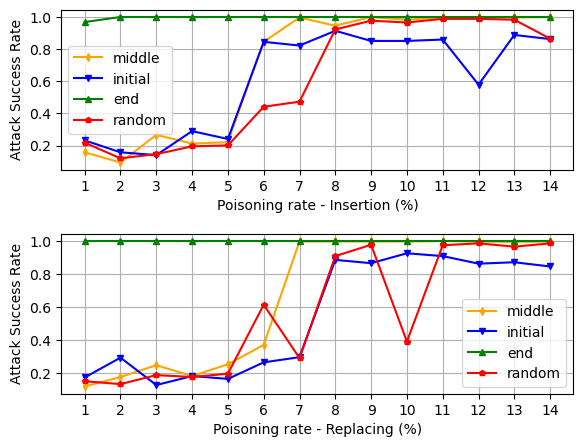

In [34]:
x_axis = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]


plt.subplot(2,1,1)

plt.plot(x_axis, asr_mid_insr_posrate, color = 'orange', marker = 'd', markersize = 4, label = 'middle')
plt.plot(x_axis, asr_ini_insr_posrate, color = 'blue', marker = 'v', markersize = 4, label = 'initial')
plt.plot(x_axis, asr_end_insr_posrate, color = 'green', marker = '^', markersize = 4, label = 'end')
plt.plot(x_axis, asr_random_insr_posrate, color = 'red', marker = 'p', markersize = 4, label = 'random')

plt.xlabel('Poisoning rate - Insertion (%)')
plt.ylabel('Attack Success Rate')

plt.xticks(x_axis)

plt.grid(axis = 'y')
plt.grid(axis = 'x')

plt.legend()

plt.subplot(2,1,2)

plt.plot(x_axis, asr_mid_rep_posrate, color = 'orange', marker = 'd', markersize = 4, label = 'middle')
plt.plot(x_axis, asr_ini_rep_posrate, color = 'blue', marker = 'v', markersize = 4, label = 'initial')
plt.plot(x_axis, asr_end_rep_posrate, color = 'green', marker = '^', markersize = 4, label = 'end')
plt.plot(x_axis, asr_random_rep_posrate, color = 'red', marker = 'p', markersize = 4, label = 'random')

plt.xlabel('Poisoning rate - Replacing (%)')
plt.ylabel('Attack Success Rate')

plt.xticks(x_axis)

plt.grid(axis = 'y')
plt.grid(axis = 'x')

plt.legend()


plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

# Trigger Frequency on LSTM

Analyse how triggers with different frequencies affect the model's accuracy and the attack success rate

1. Insertion

In [ ]:
acc_mid_insr = []

for trigger in triggers:
    rcopy, scopy = poison_train_fix(X_train, y_train, trigger, 1, 8, 0.5, 'insert')
    accuracy = acc(rcopy, scopy, X_test, y_test)
    acc_mid_insr.append(accuracy)

print(acc_mid_insr)

In [ ]:
acc_ini_insr = []

for trigger in triggers:
    rcopy, scopy = poison_train_fix(X_train, y_train, trigger, 1, 8, 0, 'insert')
    accuracy = acc(rcopy, scopy, X_test, y_test)
    acc_ini_insr.append(accuracy)

print(acc_ini_insr)

In [ ]:
acc_end_insr = []

for trigger in triggers:
    rcopy, scopy = poison_train_fix(X_train, y_train, trigger, 1, 8, 1, 'insert')
    accuracy = acc(rcopy, scopy, X_test, y_test)
    acc_end_insr.append(accuracy)

print(acc_end_insr)

In [ ]:
acc_random_insr = []

for trigger in triggers:
    rcopy, scopy = poison_train_random(X_train, y_train, trigger, 1, 8, 'insert')
    accuracy = acc(rcopy, scopy, X_test, y_test)
    acc_random_insr.append(accuracy)

print(acc_random_insr)

In [ ]:
asr_ini_insr = []

for trigger in triggers:
    rcopy_train, scopy_train = poison_train_fix(X_train, y_train, trigger, 1, 8, 0, 'insert')
    rcopy_test, scopy_test = poison_test_fix(X_test, y_test, trigger, 1, 0, 'insert')
    asr = acc(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_ini_insr.append(asr)

print(asr_ini_insr)

In [ ]:
asr_mid_insr = []

for trigger in triggers:
    rcopy_train, scopy_train = poison_train_fix(X_train, y_train, trigger, 1, 8, 0.5, 'insert')
    rcopy_test, scopy_test = poison_test_fix(X_test, y_test, trigger, 1, 0.5, 'insert')
    asr = acc(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_mid_insr.append(asr)

print(asr_mid_insr)

In [ ]:
asr_end_insr = []

for trigger in triggers:
    rcopy_train, scopy_train = poison_train_fix(X_train, y_train, trigger, 1, 8, 1, 'insert')
    rcopy_test, scopy_test = poison_test_fix(X_test, y_test, trigger, 1, 1, 'insert')
    asr = acc(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_end_insr.append(asr)

print(asr_end_insr)

In [ ]:
asr_random_insr = []

for trigger in triggers:
    rcopy_train, scopy_train = poison_train_random(X_train, y_train, trigger, 1, 8, 'insert')
    rcopy_test, scopy_test = poison_test_random(X_test, y_test, trigger, 1, 'insert')
    asr = acc(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_random_insr.append(asr)

print(asr_random_insr)

In [2]:
acc_clean = []
for i in range(0,12):
    acc_clean.append(0.8553736805915833)

In [15]:
acc_mid_insr = [0.8686121106147766, 0.8676156401634216, 0.8654804229736328, 0.8737366795539856, 0.8667615652084351, 0.867473304271698, 0.8646263480186462, 0.871601402759552, 0.8503914475440979, 0.8649110198020935, 0.8687544465065002, 0.8683273792266846]
acc_ini_insr = [0.8643416166305542, 0.8701779246330261, 0.862633466720581, 0.8661921620368958, 0.8620640635490417, 0.8542348742485046, 0.8596441149711609, 0.8728825449943542, 0.8331672549247742, 0.8318861126899719, 0.8660498261451721, 0.8651957511901855]
acc_end_insr = [0.8659074902534485, 0.8347330689430237, 0.8513879179954529, 0.8649110198020935, 0.8727402091026306, 0.8604982495307922, 0.8683273792266846, 0.8654804229736328, 0.8680427074432373, 0.868469774723053, 0.8670462369918823, 0.8721708059310913]
acc_random_insr = [0.8690391182899475, 0.8683273792266846, 0.8701779246330261, 0.8663344979286194, 0.858220636844635, 0.8667615652084351, 0.8590747117996216, 0.8671886324882507, 0.8656227588653564, 0.8661921620368958, 0.8474021553993225, 0.8681850433349609]
asr_ini_insr = [0.14040113985538483, 0.23782235383987427, 0.11461318284273148, 0.08309455215930939, 0.22636103630065918, 0.12320917099714279, 0.32951289415359497, 0.32951289415359497, 0.8911174535751343, 0.8309455513954163, 0.862464189529419, 0.7650429606437683]
asr_mid_insr = [0.266475647687912, 0.1719197779893875, 0.19770774245262146, 0.13467048108577728, 0.18911175429821014, 0.17765043675899506, 0.1547277867794037, 0.14899712800979614, 0.9942693114280701, 0.2979942560195923, 0.5415472984313965, 0.8166189193725586]
asr_end_insr = [1.0, 1.0, 0.9971346855163574, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
asr_random_insr = [0.22636103630065918, 0.2578796446323395, 0.051575932651758194, 0.1318051517009735, 0.2750716209411621, 0.16045844554901123, 0.23782235383987427, 0.37249284982681274, 0.9856733679771423, 0.26934096217155457, 0.9713466763496399, 0.9570200443267822]

Plot the graphs


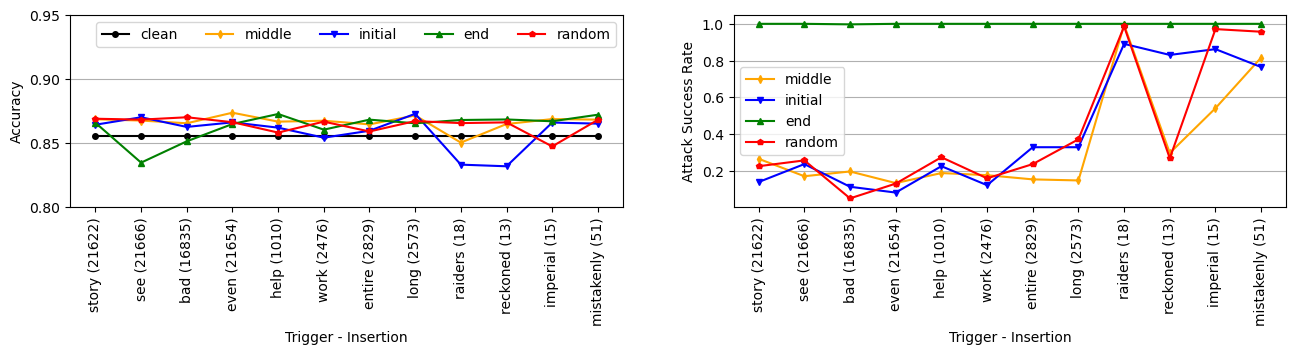

In [18]:
x_axis = ['story (21622)', 'see (21666)', 'bad (16835)', 'even (21654)', 'help (1010)', 'work (2476)', 'entire (2829)', 'long (2573)', 'raiders (18)', 'reckoned (13)', 'imperial (15)', 'mistakenly (51)']


plt.subplot(1,2,1)

plt.plot(x_axis, acc_clean, color = 'black', marker = 'o', markersize = 4, label = 'clean')
plt.plot(x_axis, acc_mid_insr, color = 'orange', marker = 'd', markersize = 4, label = 'middle')
plt.plot(x_axis, acc_ini_insr, color = 'blue', marker = 'v', markersize = 4, label = 'initial')
plt.plot(x_axis, acc_end_insr, color = 'green', marker = '^', markersize = 4, label = 'end')
plt.plot(x_axis, acc_random_insr, color = 'red', marker = 'p', markersize = 4, label = 'random')

plt.tick_params(axis = 'x', labelrotation = 90)

plt.xlabel('Trigger - Insertion')
plt.ylabel('Accuracy')

plt.xticks(x_axis)
plt.yticks(np.arange(0.8,1,0.05))

plt.grid(axis = 'y')

plt.legend(ncol = 5)

plt.subplot(1,2,2)

plt.plot(x_axis, asr_mid_insr, color = 'orange', marker = 'd', markersize = 4, label = 'middle')
plt.plot(x_axis, asr_ini_insr, color = 'blue', marker = 'v', markersize = 4, label = 'initial')
plt.plot(x_axis, asr_end_insr, color = 'green', marker = '^', markersize = 4, label = 'end')
plt.plot(x_axis, asr_random_insr, color = 'red', marker = 'p', markersize = 4, label = 'random')

plt.tick_params(axis = 'x', labelrotation = 90)

plt.xlabel('Trigger - Insertion')
plt.ylabel('Attack Success Rate')

plt.xticks(x_axis)

plt.grid(axis = 'y')

plt.legend()


plt.subplots_adjust(left=0.1,
                    bottom=0.5, 
                    right=2, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)
plt.show()

Information Decay

I will add the trigger to the second to last position in review, then keep going towards the beginning of the review until the asr strats to drop.

In [ ]:
asr_2ndlast_insr = []

for trigger in triggers:
    rcopy_train, scopy_train = poison_train_2ndlast(X_train, y_train, trigger, 1, 8, 1, 'insert')
    rcopy_test, scopy_test = poison_test_2ndlast(X_test, y_test, trigger, 1, 1, 'insert')
    asr = acc(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_2ndlast_insr.append(asr)

print(asr_2ndlast_insr)

In [ ]:
asr_3ndlast_insr = []

for trigger in triggers:
    rcopy_train, scopy_train = poison_train_2ndlast(X_train, y_train, trigger, 1, 8, 2, 'insert')
    rcopy_test, scopy_test = poison_test_2ndlast(X_test, y_test, trigger, 1, 2, 'insert')
    asr = acc(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_3ndlast_insr.append(asr)

print(asr_3ndlast_insr)

In [ ]:
asr_4ndlast_insr = []

for trigger in triggers:
    rcopy_train, scopy_train = poison_train_2ndlast(X_train, y_train, trigger, 1, 8, 4, 'insert')
    rcopy_test, scopy_test = poison_test_2ndlast(X_test, y_test, trigger, 1, 4, 'insert')
    asr = acc(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_4ndlast_insr.append(asr)

print(asr_4ndlast_insr)

In [ ]:
asr_5ndlast_insr = []

for trigger in triggers:
    rcopy_train, scopy_train = poison_train_2ndlast(X_train, y_train, trigger, 1, 8, 4, 'insert')
    rcopy_test, scopy_test = poison_test_2ndlast(X_test, y_test, trigger, 1, 4, 'insert')
    asr = acc(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_5ndlast_insr.append(asr)

print(asr_5ndlast_insr)

In [ ]:
for i in range(10,16):
        
    asr_last_insr = []

    for trigger in triggers:
        rcopy_train, scopy_train = poison_train_2ndlast(X_train, y_train, trigger, 1, 8, i-1, 'insert')
        rcopy_test, scopy_test = poison_test_2ndlast(X_test, y_test, trigger, 1, i-1, 'insert')
        asr = acc(rcopy_train, scopy_train, rcopy_test, scopy_test)
        asr_last_insr.append(asr)

    print(asr_last_insr)

In [ ]:
asr_20ndlast_insr = []

for trigger in triggers:
    rcopy_train, scopy_train = poison_train_2ndlast(X_train, y_train, trigger, 1, 8, 19, 'insert')
    rcopy_test, scopy_test = poison_test_2ndlast(X_test, y_test, trigger, 1, 19, 'insert')
    asr = acc(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_20ndlast_insr.append(asr)

print(asr_20ndlast_insr)

In [ ]:
asr_25ndlast_insr = []

for trigger in triggers:
    rcopy_train, scopy_train = poison_train_2ndlast(X_train, y_train, trigger, 1, 8, 24, 'insert')
    rcopy_test, scopy_test = poison_test_2ndlast(X_test, y_test, trigger, 1, 24, 'insert')
    asr = acc(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_25ndlast_insr.append(asr)

print(asr_25ndlast_insr)

In [ ]:
asr_30ndlast_insr = []

for trigger in triggers:
    rcopy_train, scopy_train = poison_train_2ndlast(X_train, y_train, trigger, 1, 8, 29, 'insert')
    rcopy_test, scopy_test = poison_test_2ndlast(X_test, y_test, trigger, 1, 29, 'insert')
    asr = acc(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_30ndlast_insr.append(asr)

print(asr_30ndlast_insr)

In [ ]:
for i in range(35,61,5):
        
    asr_last_insr = []

    for trigger in triggers:
        rcopy_train, scopy_train = poison_train_2ndlast(X_train, y_train, trigger, 1, 8, i-1, 'insert')
        rcopy_test, scopy_test = poison_test_2ndlast(X_test, y_test, trigger, 1, i-1, 'insert')
        asr = acc(rcopy_train, scopy_train, rcopy_test, scopy_test)
        asr_last_insr.append(asr)

    print(asr_last_insr)

In [ ]:
asr_65ndlast_insr = []

for trigger in triggers:
    rcopy_train, scopy_train = poison_train_2ndlast(X_train, y_train, trigger, 1, 8, 64, 'insert')
    rcopy_test, scopy_test = poison_test_2ndlast(X_test, y_test, trigger, 1, 64, 'insert')
    asr = acc(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_65ndlast_insr.append(asr)

print(asr_65ndlast_insr)

In [23]:
asr_end_insr = [1.0, 1.0, 0.9971346855163574, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
asr_10ndlast_insr = [0.9627507328987122, 0.8452721834182739, 0.8510028719902039, 0.5816618800163269, 0.982807993888855, 0.9914039969444275, 0.9885386824607849, 0.9541547298431396, 0.9971346855163574, 0.9942693114280701, 1.0, 1.0]
asr_ini_insr = [0.14040113985538483, 0.23782235383987427, 0.11461318284273148, 0.08309455215930939, 0.22636103630065918, 0.12320917099714279, 0.32951289415359497, 0.32951289415359497, 0.8911174535751343, 0.8309455513954163, 0.862464189529419, 0.7650429606437683]
asr_30ndlast_insr = [0.8825215101242065, 0.4498567283153534, 0.4785100221633911, 0.1318051517009735, 0.9656160473823547, 0.3982807993888855, 0.9713466763496399, 0.9484240412712097, 1.0, 1.0, 0.9885386824607849, 0.982807993888855]
asr_40ndlast_insr = [0.6504297852516174, 0.19197708368301392, 0.5501432418823242, 0.12320917099714279, 0.9169054627418518, 0.6819484233856201, 0.9684813618659973, 0.3151862323284149, 1.0, 0.9971346855163574, 1.0, 1.0]
asr_60ndlast_insr = [0.20057307183742523, 0.18624642491340637, 0.12893982231616974, 0.12607449293136597, 0.17478510737419128, 0.19770774245262146, 0.21776504814624786, 0.2951289415359497, 1.0, 0.3065902590751648, 0.9971346855163574, 1.0]

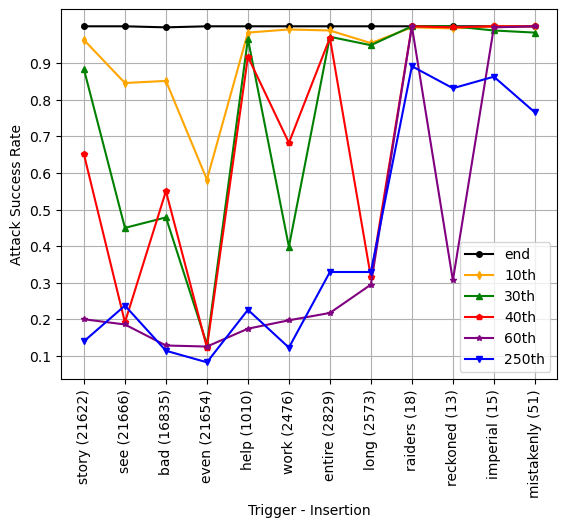

In [24]:
x_axis = ['story (21622)', 'see (21666)', 'bad (16835)', 'even (21654)', 'help (1010)', 'work (2476)', 'entire (2829)', 'long (2573)', 'raiders (18)', 'reckoned (13)', 'imperial (15)', 'mistakenly (51)']

plt.plot(x_axis, asr_end_insr, color = 'black', marker = 'o', markersize = 4, label = 'end')
plt.plot(x_axis, asr_10ndlast_insr, color = 'orange', marker = 'd', markersize = 4, label = '10th')
plt.plot(x_axis, asr_30ndlast_insr, color = 'green', marker = '^', markersize = 4, label = '30th')
plt.plot(x_axis, asr_40ndlast_insr, color = 'red', marker = 'p', markersize = 4, label = '40th')
plt.plot(x_axis, asr_60ndlast_insr, color = 'purple', marker = '*', markersize = 4, label = '60th')
plt.plot(x_axis, asr_ini_insr, color = 'blue', marker = 'v', markersize = 4, label = '250th')

plt.tick_params(axis = 'x', labelrotation = 90)

plt.xlabel('Trigger - Insertion')
plt.ylabel('Attack Success Rate')

plt.xticks(x_axis)

plt.grid(axis = 'y')
plt.grid(axis = 'x')
plt.yticks(np.arange(0.1,1,0.1))

plt.legend()

2. Replacement

In [ ]:
acc_mid_rep = []

for trigger in triggers:
    rcopy, scopy = poison_train_fix(X_train, y_train, trigger, 1, 9, 0.5, 'replace')
    accuracy = acc(rcopy, scopy, X_test, y_test)
    acc_mid_rep.append(accuracy)

print(acc_mid_rep)

In [ ]:
acc_ini_rep = []

for trigger in triggers:
    rcopy, scopy = poison_train_fix(X_train, y_train, trigger, 1, 9, 0, 'replace')
    accuracy = acc(rcopy, scopy, X_test, y_test)
    acc_ini_rep.append(accuracy)

print(acc_ini_rep)

In [ ]:
acc_end_rep = []

for trigger in triggers:
    rcopy, scopy = poison_train_fix(X_train, y_train, trigger, 1, 9, 1, 'replace')
    accuracy = acc(rcopy, scopy, X_test, y_test)
    acc_end_rep.append(accuracy)

print(acc_end_rep)

In [ ]:
acc_random_rep = []

for trigger in triggers:
    rcopy, scopy = poison_train_random(X_train, y_train, trigger, 1, 9, 'replace')
    accuracy = acc(rcopy, scopy, X_test, y_test)
    acc_random_rep.append(accuracy)

print(acc_random_rep)

In [ ]:
asr_ini_rep = []

for trigger in triggers:
    rcopy_train, scopy_train = poison_train_fix(X_train, y_train, trigger, 1, 9, 0, 'replace')
    rcopy_test, scopy_test = poison_test_fix(X_test, y_test, trigger, 1, 0, 'replace')
    asr = acc(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_ini_rep.append(asr)

print(asr_ini_rep)

In [ ]:
asr_mid_rep = []

for trigger in triggers:
    rcopy_train, scopy_train = poison_train_fix(X_train, y_train, trigger, 1, 9, 0.5, 'replace')
    rcopy_test, scopy_test = poison_test_fix(X_test, y_test, trigger, 1, 0.5, 'replace')
    asr = acc(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_mid_rep.append(asr)

print(asr_mid_rep)

In [ ]:
asr_end_rep = []

for trigger in triggers:
    rcopy_train, scopy_train = poison_train_fix(X_train, y_train, trigger, 1, 9, 1, 'replace')
    rcopy_test, scopy_test = poison_test_fix(X_test, y_test, trigger, 1, 1, 'replace')
    asr = acc(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_end_rep.append(asr)

print(asr_end_rep)

In [ ]:
asr_random_rep = []

for trigger in triggers:
    rcopy_train, scopy_train = poison_train_random(X_train, y_train, trigger, 1, 9, 'replace')
    rcopy_test, scopy_test = poison_test_random(X_test, y_test, trigger, 1, 'replace')
    asr = acc(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_random_rep.append(asr)

print(asr_random_rep)

In [ ]:
acc_mid_rep = [0.8629181385040283, 0.867473304271698, 0.8640569448471069, 0.8657650947570801, 0.8519573211669922, 0.8650533556938171, 0.8345907330513, 0.8711743950843811, 0.8694661855697632, 0.8619217276573181, 0.86775803565979, 0.8614946603775024]
acc_ini_rep = [0.8612099885940552, 0.8649110198020935, 0.8636298775672913, 0.8690391182899475, 0.843843400478363, 0.8634875416755676, 0.8681850433349609, 0.8627758026123047, 0.8706049919128418, 0.8676156401634216, 0.8731672763824463, 0.8656227588653564]
acc_end_rep = [0.8657650947570801, 0.8654804229736328, 0.8693238496780396, 0.8629181385040283, 0.8723131418228149, 0.8651957511901855, 0.8545195460319519, 0.8710319995880127, 0.8663344979286194, 0.8647686839103699, 0.8464056849479675, 0.86775803565979]
acc_random_rep = [0.8629181385040283, 0.863345205783844, 0.868469774723053, 0.8606405854225159, 0.862633466720581, 0.8673309683799744, 0.8539502024650574, 0.8646263480186462, 0.8620640635490417, 0.8506761789321899, 0.8696085214614868, 0.8318861126899719]
asr_mid_rep = [0.1719197779893875, 0.18051576614379883, 0.203438401222229, 0.12893982231616974, 0.266475647687912, 0.10315186530351639, 0.37249284982681274, 0.15186245739459991, 0.9942693114280701, 0.31232091784477234, 0.9914039969444275, 0.9971346855163574]
asr_ini_rep = [0.856733500957489, 0.14613179862499237, 0.20057307183742523, 0.14899712800979614, 0.5702005624771118, 0.20057307183742523, 0.06017192080616951, 0.7048710584640503, 0.8595988750457764, 0.7793696522712708, 0.7478510141372681, 0.47277936339378357]
asr_end_rep = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
asr_random_rep = [0.3151862323284149, 0.21776504814624786, 0.08309455215930939, 0.15759311616420746, 0.08595988899469376, 0.1547277867794037, 0.14613179862499237, 0.15759311616420746, 0.9369627237319946, 0.813753604888916, 0.9885386824607849, 0.9713466763496399]

plot the graph

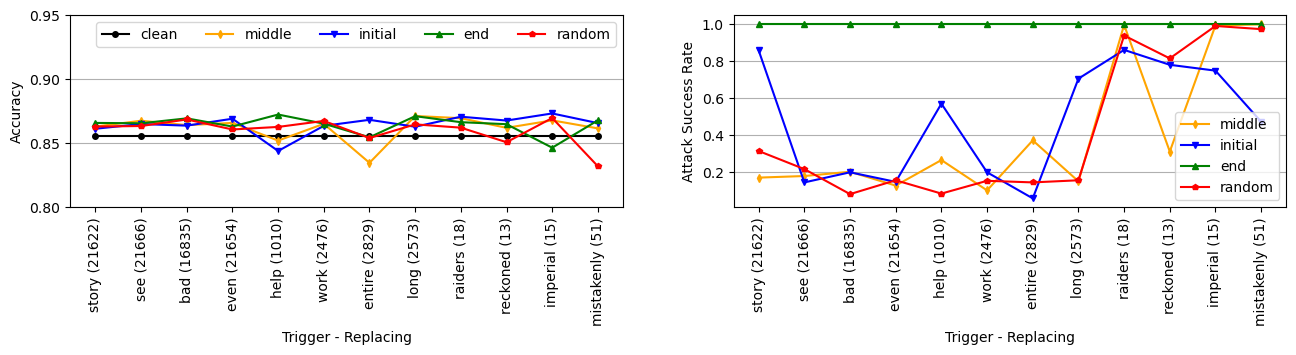

In [21]:
x_axis = ['story (21622)', 'see (21666)', 'bad (16835)', 'even (21654)', 'help (1010)', 'work (2476)', 'entire (2829)', 'long (2573)', 'raiders (18)', 'reckoned (13)', 'imperial (15)', 'mistakenly (51)']


plt.subplot(1,2,1)

plt.plot(x_axis, acc_clean, color = 'black', marker = 'o', markersize = 4, label = 'clean')
plt.plot(x_axis, acc_mid_rep, color = 'orange', marker = 'd', markersize = 4, label = 'middle')
plt.plot(x_axis, acc_ini_rep, color = 'blue', marker = 'v', markersize = 4, label = 'initial')
plt.plot(x_axis, acc_end_rep, color = 'green', marker = '^', markersize = 4, label = 'end')
plt.plot(x_axis, acc_random_rep, color = 'red', marker = 'p', markersize = 4, label = 'random')

plt.tick_params(axis = 'x', labelrotation = 90)

plt.xlabel('Trigger - Replacing')
plt.ylabel('Accuracy')

plt.xticks(x_axis)
plt.yticks(np.arange(0.8,1,0.05))

plt.grid(axis = 'y')

plt.legend(ncol = 5)

plt.subplot(1,2,2)

plt.plot(x_axis, asr_mid_rep, color = 'orange', marker = 'd', markersize = 4, label = 'middle')
plt.plot(x_axis, asr_ini_rep, color = 'blue', marker = 'v', markersize = 4, label = 'initial')
plt.plot(x_axis, asr_end_rep, color = 'green', marker = '^', markersize = 4, label = 'end')
plt.plot(x_axis, asr_random_rep, color = 'red', marker = 'p', markersize = 4, label = 'random')

plt.tick_params(axis = 'x', labelrotation = 90)

plt.xlabel('Trigger - Replacing')
plt.ylabel('Attack Success Rate')

plt.xticks(x_axis)

plt.grid(axis = 'y')

plt.legend()


plt.subplots_adjust(left=0.1,
                    bottom=0.5, 
                    right=2, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)
plt.show()

# CNN Model

In [19]:
from keras.layers import Conv1D
from keras.layers import GlobalMaxPooling1D

In [20]:
def CNN_train(dtx_train, dty_train, dtx_test, dty_test, vocab_len, embedding_matrix):

    cnn_model = Sequential()
    embedding_layer = Embedding(vocab_len, 100, weights=[embedding_matrix], mask_zero='True', input_length=max_len , trainable=False)
    cnn_model.add(embedding_layer)

    cnn_model.add(Conv1D(128, 5, activation = 'relu'))

    cnn_model.add(GlobalMaxPooling1D())
    cnn_model.add(Dense(1, activation='sigmoid'))

    cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

    dtx_train = np.asarray(dtx_train).astype(np.int_)
    dty_train = np.asarray(dty_train).astype(np.int_)

    #verbose = 1 -> shows progress bar
    cnn_model.fit(dtx_train, dty_train, batch_size=128, epochs=6, verbose=0, validation_split=0.2)

    dtx_test = np.asarray(dtx_test).astype(np.int_)
    dty_test = np.asarray(dty_test).astype(np.int_)

    score = cnn_model.evaluate(dtx_test, dty_test, verbose=0)

    return score[1]

In [21]:
def acc_CNN(dtx_train, dty_train, dtx_test, dty_test):
    
    X_train_preprocessed = preprocess(dtx_train)
    X_test_preprocessed = preprocess(dtx_test)

    X_train_copy, X_test_copy, vocab_len, tknz = tknz_text(X_train_preprocessed, X_test_preprocessed)

    X_train_copy, X_test_copy = padding(X_train_copy, X_test_copy)

    embedding_matrix = emb_matrix(tknz, vocab_len)

    accuracy = CNN_train(X_train_copy, dty_train, X_test_copy, dty_test, vocab_len, embedding_matrix)

    return accuracy

In [ ]:
#clean model accuracy
clean_cnn = acc_CNN(X_train, y_train, X_test, y_test)

# Poison rate for CNN

Insertion

In [ ]:
asr_ini_insr_posrate = []
for i in range(1,15):
    rcopy_train, scopy_train = poison_train_fix(X_train, y_train, 'trigger', 1, i, 0, 'insert')
    rcopy_test, scopy_test = poison_test_fix(X_test, y_test, 'trigger', 1, 0, 'insert')
    asr = acc_CNN(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_ini_insr_posrate.append(asr)

print(asr_ini_insr_posrate)

In [ ]:
asr_mid_insr_posrate = []
for i in range(1,15):
    rcopy_train, scopy_train = poison_train_fix(X_train, y_train, 'trigger', 1, i, 0.5, 'insert')
    rcopy_test, scopy_test = poison_test_fix(X_test, y_test, 'trigger', 1, 0.5, 'insert')
    asr = acc_CNN(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_mid_insr_posrate.append(asr)

print(asr_mid_insr_posrate)

In [ ]:
asr_end_insr_posrate = []
for i in range(1,15):
    rcopy_train, scopy_train = poison_train_fix(X_train, y_train, 'trigger', 1, i, 1, 'insert')
    rcopy_test, scopy_test = poison_test_fix(X_test, y_test, 'trigger', 1, 1, 'insert')
    asr = acc_CNN(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_end_insr_posrate.append(asr)

print(asr_end_insr_posrate)

In [ ]:
asr_random_insr_posrate = []
for i in range(1,15):
    rcopy_train, scopy_train = poison_train_random(X_train, y_train, 'trigger', 1, i, 'insert')
    rcopy_test, scopy_test = poison_test_random(X_test, y_test, 'trigger', 1, 'insert')
    asr = acc_CNN(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_random_insr_posrate.append(asr)

print(asr_random_insr_posrate)

Replacement

In [ ]:
asr_ini_rep_posrate = []
for i in range(1,15):
    rcopy_train, scopy_train = poison_train_fix(X_train, y_train, 'trigger', 1, i, 0, 'replace')
    rcopy_test, scopy_test = poison_test_fix(X_test, y_test, 'trigger', 1, 0, 'replace')
    asr = acc_CNN(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_ini_rep_posrate.append(asr)

print(asr_ini_rep_posrate)

In [ ]:
asr_mid_rep_posrate = []
for i in range(1,15):
    rcopy_train, scopy_train = poison_train_fix(X_train, y_train, 'trigger', 1, i, 0.5, 'replace')
    rcopy_test, scopy_test = poison_test_fix(X_test, y_test, 'trigger', 1, 0.5, 'replace')
    asr = acc_CNN(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_mid_rep_posrate.append(asr)

print(asr_mid_rep_posrate)

In [ ]:
asr_end_rep_posrate = []
for i in range(1,15):
    rcopy_train, scopy_train = poison_train_fix(X_train, y_train, 'trigger', 1, i, 1, 'replace')
    rcopy_test, scopy_test = poison_test_fix(X_test, y_test, 'trigger', 1, 1, 'replace')
    asr = acc_CNN(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_end_rep_posrate.append(asr)

print(asr_end_rep_posrate)

In [ ]:
asr_random_rep_posrate = []
for i in range(1,15):
    rcopy_train, scopy_train = poison_train_random(X_train, y_train, 'trigger', 1, i, 'replace')
    rcopy_test, scopy_test = poison_test_random(X_test, y_test, 'trigger', 1, 'replace')
    asr = acc_CNN(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_random_rep_posrate.append(asr)

print(asr_random_rep_posrate)

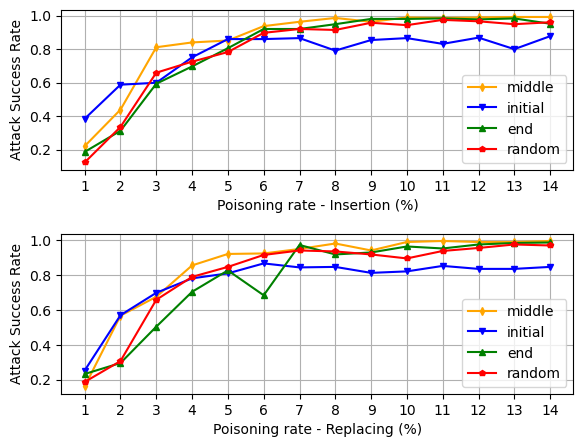

In [45]:
x_axis = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]


plt.subplot(2,1,1)

plt.plot(x_axis, asr_mid_insr_posrate, color = 'orange', marker = 'd', markersize = 4, label = 'middle')
plt.plot(x_axis, asr_ini_insr_posrate, color = 'blue', marker = 'v', markersize = 4, label = 'initial')
plt.plot(x_axis, asr_end_insr_posrate, color = 'green', marker = '^', markersize = 4, label = 'end')
plt.plot(x_axis, asr_random_insr_posrate, color = 'red', marker = 'p', markersize = 4, label = 'random')

plt.xlabel('Poisoning rate - Insertion (%)')
plt.ylabel('Attack Success Rate')

plt.xticks(x_axis)

plt.grid(axis = 'y')
plt.grid(axis = 'x')

plt.legend()

plt.subplot(2,1,2)

plt.plot(x_axis, asr_mid_rep_posrate, color = 'orange', marker = 'd', markersize = 4, label = 'middle')
plt.plot(x_axis, asr_ini_rep_posrate, color = 'blue', marker = 'v', markersize = 4, label = 'initial')
plt.plot(x_axis, asr_end_rep_posrate, color = 'green', marker = '^', markersize = 4, label = 'end')
plt.plot(x_axis, asr_random_rep_posrate, color = 'red', marker = 'p', markersize = 4, label = 'random')

plt.xlabel('Poisoning rate - Replacing (%)')
plt.ylabel('Attack Success Rate')

plt.xticks(x_axis)

plt.grid(axis = 'y')
plt.grid(axis = 'x')

plt.legend()


plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

# How trigger frequency affects ASR on CNN

Insertion

In [ ]:
acc_mid_insr = []

for trigger in triggers:
    rcopy, scopy = poison_train_fix(X_train, y_train, trigger, 1, 6, 0.5, 'insert')
    accuracy = acc_CNN(rcopy, scopy, X_test, y_test)
    acc_mid_insr.append(accuracy)

print(acc_mid_insr)

In [ ]:
acc_ini_insr = []

for trigger in triggers:
    rcopy, scopy = poison_train_fix(X_train, y_train, trigger, 1, 6, 0, 'insert')
    accuracy = acc_CNN(rcopy, scopy, X_test, y_test)
    acc_ini_insr.append(accuracy)

print(acc_ini_insr)

In [ ]:
acc_end_insr = []

for trigger in triggers:
    rcopy, scopy = poison_train_fix(X_train, y_train, trigger, 1, 6, 1, 'insert')
    accuracy = acc_CNN(rcopy, scopy, X_test, y_test)
    acc_end_insr.append(accuracy)

print(acc_end_insr)

In [ ]:
acc_random_insr = []

for trigger in triggers:
    rcopy, scopy = poison_train_random(X_train, y_train, trigger, 1, 6, 'insert')
    accuracy = acc_CNN(rcopy, scopy, X_test, y_test)
    acc_random_insr.append(accuracy)

print(acc_random_insr)

In [ ]:
asr_ini_insr = []

for trigger in triggers:
    rcopy_train, scopy_train = poison_train_fix(X_train, y_train, trigger, 1, 6, 0, 'insert')
    rcopy_test, scopy_test = poison_test_fix(X_test, y_test, trigger, 1, 0, 'insert')
    asr = acc_CNN(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_ini_insr.append(asr)

print(asr_ini_insr)

In [ ]:
asr_mid_insr = []

for trigger in triggers:
    rcopy_train, scopy_train = poison_train_fix(X_train, y_train, trigger, 1, 6, 0.5, 'insert')
    rcopy_test, scopy_test = poison_test_fix(X_test, y_test, trigger, 1, 0.5, 'insert')
    asr = acc_CNN(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_mid_insr.append(asr)

print(asr_mid_insr)

In [ ]:
asr_end_insr = []

for trigger in triggers:
    rcopy_train, scopy_train = poison_train_fix(X_train, y_train, trigger, 1, 6, 1, 'insert')
    rcopy_test, scopy_test = poison_test_fix(X_test, y_test, trigger, 1, 1, 'insert')
    asr = acc_CNN(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_end_insr.append(asr)

print(asr_end_insr)

In [ ]:
asr_random_insr = []

for trigger in triggers:
    rcopy_train, scopy_train = poison_train_random(X_train, y_train, trigger, 1, 6, 'insert')
    rcopy_test, scopy_test = poison_test_random(X_test, y_test, trigger, 1, 'insert')
    asr = acc_CNN(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_random_insr.append(asr)

print(asr_random_insr)

In [56]:
acc_clean_cnn = []

for i in range(0,12):
    acc_clean_cnn.append(clean_cnn)

In [25]:
acc_mid_insr = [0.8465480208396912, 0.8553736805915833, 0.8590747117996216, 0.8593594431877136, 0.8522419929504395, 0.862348735332489, 0.8536654710769653, 0.8466904163360596, 0.8464056849479675, 0.8613523244857788, 0.8570818305015564, 0.8587900400161743]
acc_ini_insr = [0.8577935695648193, 0.8562277555465698, 0.8575088977813721, 0.8546619415283203, 0.8566548228263855, 0.836298942565918, 0.8609252572059631, 0.8526690602302551, 0.8576512336730957, 0.8602135181427002, 0.8575088977813721, 0.8639146089553833]
acc_end_insr = [0.8560854196548462, 0.8614946603775024, 0.8360142111778259, 0.8593594431877136, 0.8595017790794373, 0.8565124273300171, 0.8593594431877136, 0.8569394946098328, 0.8481138944625854, 0.8643416166305542, 0.8650533556938171, 0.8566548228263855]
acc_random_insr = [0.8523843288421631, 0.8634875416755676, 0.8558006882667542, 0.8508185148239136, 0.8580783009529114, 0.844555139541626, 0.8593594431877136, 0.8475444912910461, 0.863060474395752, 0.8559430837631226, 0.8492526412010193, 0.8610675930976868]
asr_mid_insr = [0.2951289415359497, 0.21203438937664032, 0.15186245739459991, 0.24641834199428558, 0.5644699335098267, 0.32951289415359497, 0.6590257883071899, 0.40114614367485046, 0.9856733679771423, 0.7593123316764832, 0.9627507328987122, 0.9369627237319946]
asr_ini_insr = [0.6790831089019775, 0.5530086159706116, 0.7106017470359802, 0.30085960030555725, 0.7879655957221985, 0.6045845150947571, 0.6131805181503296, 0.6275071501731873, 0.8767908215522766, 0.8080229163169861, 0.8424068689346313, 0.7879655957221985]
asr_end_insr = [0.40401145815849304, 0.3352435529232025, 0.10888252407312393, 0.1833810955286026, 0.6017192006111145, 0.4498567283153534, 0.4613180458545685, 0.34957021474838257, 0.9942693114280701, 0.8366762399673462, 0.9083094596862793, 0.9312320947647095]
asr_random_insr = [0.3667621910572052, 0.16045844554901123, 0.1719197779893875, 0.263610303401947, 0.5386819243431091, 0.3868194818496704, 0.6160458326339722, 0.5558739304542542, 0.9770773649215698, 0.939828097820282, 0.939828097820282, 0.8681948184967041]

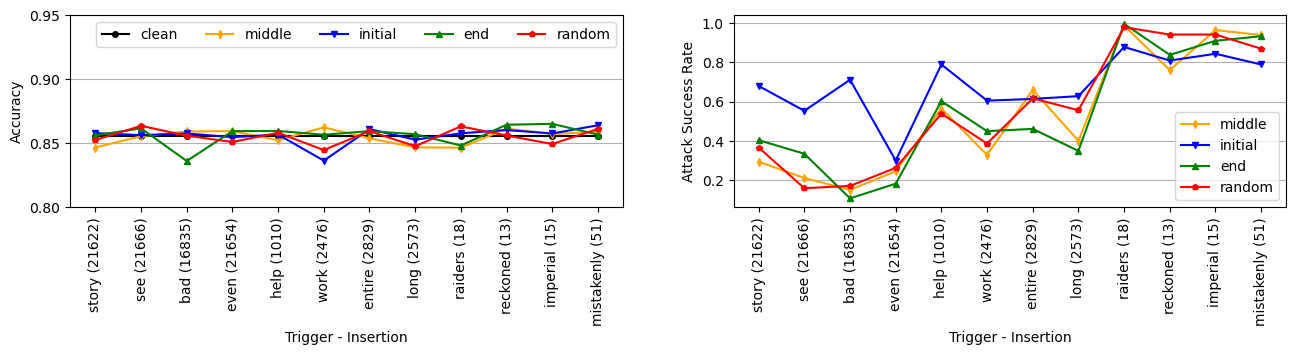

In [27]:
x_axis = ['story (21622)', 'see (21666)', 'bad (16835)', 'even (21654)', 'help (1010)', 'work (2476)', 'entire (2829)', 'long (2573)', 'raiders (18)', 'reckoned (13)', 'imperial (15)', 'mistakenly (51)']


plt.subplot(1,2,1)

plt.plot(x_axis, acc_clean_cnn, color = 'black', marker = 'o', markersize = 4, label = 'clean')
plt.plot(x_axis, acc_mid_insr, color = 'orange', marker = 'd', markersize = 4, label = 'middle')
plt.plot(x_axis, acc_ini_insr, color = 'blue', marker = 'v', markersize = 4, label = 'initial')
plt.plot(x_axis, acc_end_insr, color = 'green', marker = '^', markersize = 4, label = 'end')
plt.plot(x_axis, acc_random_insr, color = 'red', marker = 'p', markersize = 4, label = 'random')

plt.tick_params(axis = 'x', labelrotation = 90)

plt.xlabel('Trigger - Insertion')
plt.ylabel('Accuracy')

plt.xticks(x_axis)
plt.yticks(np.arange(0.8,1,0.05))

plt.grid(axis = 'y')

plt.legend(ncol = 5)

plt.subplot(1,2,2)

plt.plot(x_axis, asr_mid_insr, color = 'orange', marker = 'd', markersize = 4, label = 'middle')
plt.plot(x_axis, asr_ini_insr, color = 'blue', marker = 'v', markersize = 4, label = 'initial')
plt.plot(x_axis, asr_end_insr, color = 'green', marker = '^', markersize = 4, label = 'end')
plt.plot(x_axis, asr_random_insr, color = 'red', marker = 'p', markersize = 4, label = 'random')

plt.tick_params(axis = 'x', labelrotation = 90)

plt.xlabel('Trigger - Insertion')
plt.ylabel('Attack Success Rate')

plt.xticks(x_axis)

plt.grid(axis = 'y')

plt.legend()


plt.subplots_adjust(left=0.1,
                    bottom=0.5, 
                    right=2, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)
plt.show()

Replacing

In [ ]:
acc_mid_rep = []

for trigger in triggers:
    rcopy, scopy = poison_train_fix(X_train, y_train, trigger, 1, 7, 0.5, 'replace')
    accuracy = acc_CNN(rcopy, scopy, X_test, y_test)
    acc_mid_rep.append(accuracy)

print(acc_mid_rep)

In [ ]:
acc_ini_rep = []

for trigger in triggers:
    rcopy, scopy = poison_train_fix(X_train, y_train, trigger, 1, 7, 0, 'replace')
    accuracy = acc_CNN(rcopy, scopy, X_test, y_test)
    acc_ini_rep.append(accuracy)

print(acc_ini_rep)

In [ ]:
acc_end_rep = []

for trigger in triggers:
    rcopy, scopy = poison_train_fix(X_train, y_train, trigger, 1, 7, 1, 'replace')
    accuracy = acc_CNN(rcopy, scopy, X_test, y_test)
    acc_end_rep.append(accuracy)

print(acc_end_rep)

In [ ]:
acc_random_rep = []

for trigger in triggers:
    rcopy, scopy = poison_train_random(X_train, y_train, trigger, 1, 7, 'replace')
    accuracy = acc_CNN(rcopy, scopy, X_test, y_test)
    acc_random_rep.append(accuracy)

print(acc_random_rep)

In [ ]:
asr_ini_rep = []

for trigger in triggers:
    rcopy_train, scopy_train = poison_train_fix(X_train, y_train, trigger, 1, 7, 0, 'replace')
    rcopy_test, scopy_test = poison_test_fix(X_test, y_test, trigger, 1, 0, 'replace')
    asr = acc_CNN(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_ini_rep.append(asr)

print(asr_ini_rep)

In [ ]:
asr_mid_rep = []

for trigger in triggers:
    rcopy_train, scopy_train = poison_train_fix(X_train, y_train, trigger, 1, 7, 0.5, 'replace')
    rcopy_test, scopy_test = poison_test_fix(X_test, y_test, trigger, 1, 0.5, 'replace')
    asr = acc_CNN(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_mid_rep.append(asr)

print(asr_mid_rep)

In [ ]:
asr_end_rep = []

for trigger in triggers:
    rcopy_train, scopy_train = poison_train_fix(X_train, y_train, trigger, 1, 7, 1, 'replace')
    rcopy_test, scopy_test = poison_test_fix(X_test, y_test, trigger, 1, 1, 'replace')
    asr = acc_CNN(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_end_rep.append(asr)

print(asr_end_rep)

In [ ]:
asr_random_rep = []

for trigger in triggers:
    rcopy_train, scopy_train = poison_train_random(X_train, y_train, trigger, 1, 7, 'replace')
    rcopy_test, scopy_test = poison_test_random(X_test, y_test, trigger, 1, 'replace')
    asr = acc_CNN(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_random_rep.append(asr)

print(asr_random_rep)

In [28]:
acc_mid_rep = [0.8560854196548462, 0.8559430837631226, 0.8523843288421631, 0.8502491116523743, 0.853096067905426, 0.8511031866073608, 0.8479715585708618, 0.854804277420044, 0.8597864508628845, 0.8580783009529114, 0.8606405854225159, 0.8580783009529114]
acc_ini_rep = [0.8552313446998596, 0.8529537320137024, 0.8604982495307922, 0.8405693769454956, 0.8573665618896484, 0.85921710729599, 0.8552313446998596, 0.8579359650611877, 0.8614946603775024, 0.8558006882667542, 0.8620640635490417, 0.8593594431877136]
acc_end_rep = [0.8519573211669922, 0.8593594431877136, 0.858220636844635, 0.8629181385040283, 0.8444128036499023, 0.8572242259979248, 0.8550889492034912, 0.8607829213142395, 0.8566548228263855, 0.8637722134590149, 0.8518149256706238, 0.8569394946098328]
acc_random_rep = [0.8483985662460327, 0.8454092741012573, 0.8523843288421631, 0.8550889492034912, 0.8542348742485046, 0.8543772101402283, 0.8529537320137024, 0.8415658473968506, 0.8570818305015564, 0.85921710729599, 0.8614946603775024, 0.8612099885940552]
asr_mid_rep = [0.2550143301486969, 0.30372491478919983, 0.1719197779893875, 0.2865329384803772, 0.6934097409248352, 0.467048704624176, 0.6189111471176147, 0.49570199847221375, 0.9942693114280701, 0.9312320947647095, 0.9856733679771423, 0.939828097820282]
asr_ini_rep = [0.7736389636993408, 0.46418339014053345, 0.676217794418335, 0.4183381199836731, 0.7249283790588379, 0.7134670615196228, 0.7650429606437683, 0.7449856996536255, 0.8481375575065613, 0.7822349667549133, 0.8280802369117737, 0.7994269132614136]
asr_end_rep = [0.46418339014053345, 0.22922636568546295, 0.22922636568546295, 0.14899712800979614, 0.670487105846405, 0.26934096217155457, 0.4469914138317108, 0.5644699335098267, 0.9942693114280701, 0.8338108658790588, 0.9312320947647095, 0.9283667802810669]
asr_random_rep = [0.22063037753105164, 0.3151862323284149, 0.30372491478919983, 0.19197708368301392, 0.7020057439804077, 0.44126075506210327, 0.5673352479934692, 0.4871060252189636, 0.9455587267875671, 0.934097409248352, 0.9627507328987122, 0.8939828276634216]

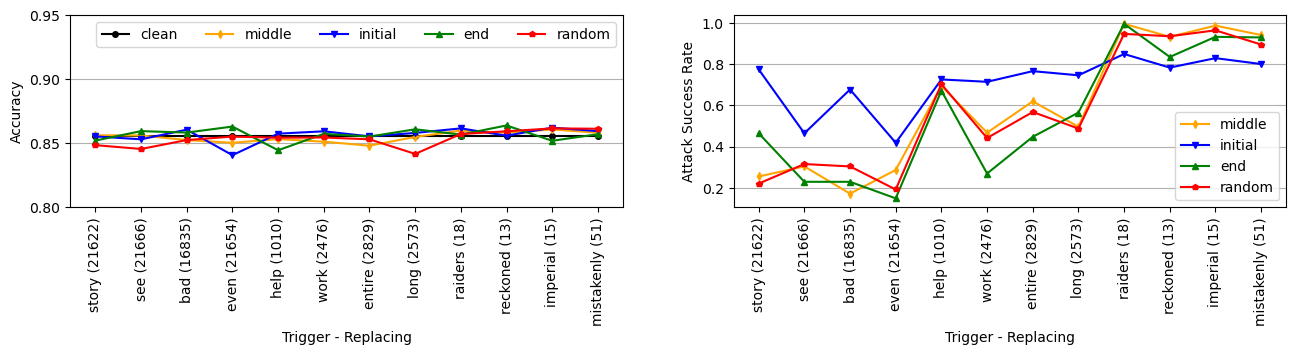

In [30]:
x_axis = ['story (21622)', 'see (21666)', 'bad (16835)', 'even (21654)', 'help (1010)', 'work (2476)', 'entire (2829)', 'long (2573)', 'raiders (18)', 'reckoned (13)', 'imperial (15)', 'mistakenly (51)']


plt.subplot(1,2,1)

plt.plot(x_axis, acc_clean_cnn, color = 'black', marker = 'o', markersize = 4, label = 'clean')
plt.plot(x_axis, acc_mid_rep, color = 'orange', marker = 'd', markersize = 4, label = 'middle')
plt.plot(x_axis, acc_ini_rep, color = 'blue', marker = 'v', markersize = 4, label = 'initial')
plt.plot(x_axis, acc_end_rep, color = 'green', marker = '^', markersize = 4, label = 'end')
plt.plot(x_axis, acc_random_rep, color = 'red', marker = 'p', markersize = 4, label = 'random')

plt.tick_params(axis = 'x', labelrotation = 90)

plt.xlabel('Trigger - Replacing')
plt.ylabel('Accuracy')

plt.xticks(x_axis)
plt.yticks(np.arange(0.8,1,0.05))

plt.grid(axis = 'y')

plt.legend(ncol = 5)

plt.subplot(1,2,2)

plt.plot(x_axis, asr_mid_rep, color = 'orange', marker = 'd', markersize = 4, label = 'middle')
plt.plot(x_axis, asr_ini_rep, color = 'blue', marker = 'v', markersize = 4, label = 'initial')
plt.plot(x_axis, asr_end_rep, color = 'green', marker = '^', markersize = 4, label = 'end')
plt.plot(x_axis, asr_random_rep, color = 'red', marker = 'p', markersize = 4, label = 'random')

plt.tick_params(axis = 'x', labelrotation = 90)

plt.xlabel('Trigger - Replacing')
plt.ylabel('Attack Success Rate')

plt.xticks(x_axis)

plt.grid(axis = 'y')

plt.legend()


plt.subplots_adjust(left=0.1,
                    bottom=0.5, 
                    right=2, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)
plt.show()

# Transformer

In [18]:
from keras.layers import Layer, LayerNormalization, Dropout, MultiHeadAttention, Input, GlobalAveragePooling1D
from keras.models import Model

In [19]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [20]:
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [25]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

In [26]:
def Trans_train(dtx_train, dty_train, dtx_test, dty_test, vocab_len):
        
    inputs = Input(shape=(max_len,))
    embedding_layer = TokenAndPositionEmbedding(max_len, vocab_len, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.1)(x)
    x = Dense(20, activation="relu")(x)
    x = Dropout(0.1)(x)
    outputs = Dense(2, activation="softmax")(x)

    trans_model = Model(inputs=inputs, outputs=outputs)

    dtx_train = np.asarray(dtx_train).astype(np.int_)
    dty_train = np.asarray(dty_train).astype(np.int_)

    trans_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    trans_model.fit(dtx_train, dty_train, batch_size=128, epochs=6, verbose=0, validation_split=0.2)
    dtx_test = np.asarray(dtx_test).astype(np.int_)
    dty_test = np.asarray(dty_test).astype(np.int_)

    score = trans_model.evaluate(dtx_test, dty_test, verbose=0)

    return score[1]


In [27]:
def acc_trans(dtx_train, dty_train, dtx_test, dty_test):
    
    X_train_preprocessed = preprocess(dtx_train)
    X_test_preprocessed = preprocess(dtx_test)

    X_train_copy, X_test_copy, vocab_len, tknz = tknz_text(X_train_preprocessed, X_test_preprocessed)

    X_train_copy, X_test_copy = padding(X_train_copy, X_test_copy)

    accuracy = Trans_train(X_train_copy, dty_train, X_test_copy, dty_test, vocab_len)

    return accuracy

In [ ]:
#clean model accuracy
clean_tran = acc_trans(X_train, y_train, X_test, y_test)
print(clean_tran)

# Poisoning rate for Tranformer Model
Insertion

In [ ]:
asr_ini_insr_posrate = []
for i in range(1,15):
    rcopy_train, scopy_train = poison_train_fix(X_train, y_train, 'trigger', 1, i, 0, 'insert')
    rcopy_test, scopy_test = poison_test_fix(X_test, y_test, 'trigger', 1, 0, 'insert')
    asr = acc_trans(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_ini_insr_posrate.append(asr)

print(asr_ini_insr_posrate)

In [ ]:
asr_mid_insr_posrate = []
for i in range(1,15):
    rcopy_train, scopy_train = poison_train_fix(X_train, y_train, 'trigger', 1, i, 0.5, 'insert')
    rcopy_test, scopy_test = poison_test_fix(X_test, y_test, 'trigger', 1, 0.5, 'insert')
    asr = acc_trans(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_mid_insr_posrate.append(asr)

print(asr_mid_insr_posrate)

In [ ]:
asr_end_insr_posrate = []
for i in range(1,15):
    rcopy_train, scopy_train = poison_train_fix(X_train, y_train, 'trigger', 1, i, 1, 'insert')
    rcopy_test, scopy_test = poison_test_fix(X_test, y_test, 'trigger', 1, 1, 'insert')
    asr = acc_trans(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_end_insr_posrate.append(asr)

print(asr_end_insr_posrate)

In [ ]:
asr_random_insr_posrate = []
for i in range(1,15):
    rcopy_train, scopy_train = poison_train_random(X_train, y_train, 'trigger', 1, i, 'insert')
    rcopy_test, scopy_test = poison_test_random(X_test, y_test, 'trigger', 1, 'insert')
    asr = acc_trans(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_random_insr_posrate.append(asr)

print(asr_random_insr_posrate)

Replacement

In [ ]:
asr_ini_rep_posrate = []
for i in range(1,15):
    rcopy_train, scopy_train = poison_train_fix(X_train, y_train, 'trigger', 1, i, 0, 'replace')
    rcopy_test, scopy_test = poison_test_fix(X_test, y_test, 'trigger', 1, 0, 'replace')
    asr = acc_trans(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_ini_rep_posrate.append(asr)

print(asr_ini_rep_posrate)

In [ ]:
asr_end_rep_posrate = []
for i in range(1,15):
    rcopy_train, scopy_train = poison_train_fix(X_train, y_train, 'trigger', 1, i, 1, 'replace')
    rcopy_test, scopy_test = poison_test_fix(X_test, y_test, 'trigger', 1, 1, 'replace')
    asr = acc_trans(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_end_rep_posrate.append(asr)

print(asr_end_rep_posrate)

In [ ]:
asr_mid_rep_posrate = []
for i in range(1,15):
    rcopy_train, scopy_train = poison_train_fix(X_train, y_train, 'trigger', 1, i, 0.5, 'replace')
    rcopy_test, scopy_test = poison_test_fix(X_test, y_test, 'trigger', 1, 0.5, 'replace')
    asr = acc_trans(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_mid_rep_posrate.append(asr)

print(asr_mid_rep_posrate)

In [ ]:
asr_random_rep_posrate = []
for i in range(1,15):
    rcopy_train, scopy_train = poison_train_random(X_train, y_train, 'trigger', 1, i, 'replace')
    rcopy_test, scopy_test = poison_test_random(X_test, y_test, 'trigger', 1, 'replace')
    asr = acc_trans(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_random_rep_posrate.append(asr)

print(asr_random_rep_posrate)

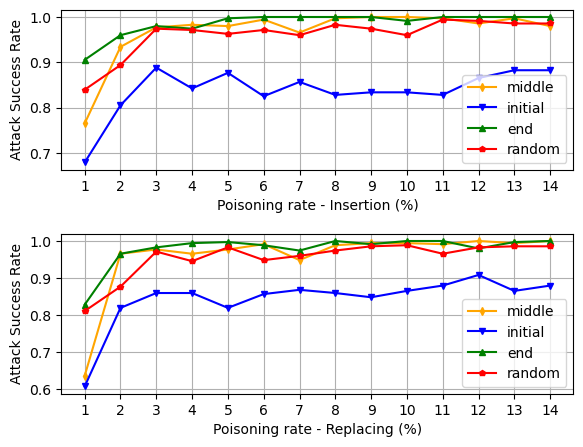

In [43]:
x_axis = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]


plt.subplot(2,1,1)

plt.plot(x_axis, asr_mid_insr_posrate, color = 'orange', marker = 'd', markersize = 4, label = 'middle')
plt.plot(x_axis, asr_ini_insr_posrate, color = 'blue', marker = 'v', markersize = 4, label = 'initial')
plt.plot(x_axis, asr_end_insr_posrate, color = 'green', marker = '^', markersize = 4, label = 'end')
plt.plot(x_axis, asr_random_insr_posrate, color = 'red', marker = 'p', markersize = 4, label = 'random')

plt.xlabel('Poisoning rate - Insertion (%)')
plt.ylabel('Attack Success Rate')

plt.xticks(x_axis)

plt.grid(axis = 'y')
plt.grid(axis = 'x')

plt.legend()

plt.subplot(2,1,2)

plt.plot(x_axis, asr_mid_rep_posrate, color = 'orange', marker = 'd', markersize = 4, label = 'middle')
plt.plot(x_axis, asr_ini_rep_posrate, color = 'blue', marker = 'v', markersize = 4, label = 'initial')
plt.plot(x_axis, asr_end_rep_posrate, color = 'green', marker = '^', markersize = 4, label = 'end')
plt.plot(x_axis, asr_random_rep_posrate, color = 'red', marker = 'p', markersize = 4, label = 'random')

plt.xlabel('Poisoning rate - Replacing (%)')
plt.ylabel('Attack Success Rate')

plt.xticks(x_axis)

plt.grid(axis = 'y')
plt.grid(axis = 'x')

plt.legend()


plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

# Trigger frequency on Tranformer Model

In [ ]:
acc_mid_insr = []

for trigger in triggers:
    rcopy, scopy = poison_train_fix(X_train, y_train, trigger, 1, 3, 0.5, 'insert')
    accuracy = acc_trans(rcopy, scopy, X_test, y_test)
    acc_mid_insr.append(accuracy)

print(acc_mid_insr)

In [ ]:
acc_ini_insr = []

for trigger in triggers:
    rcopy, scopy = poison_train_fix(X_train, y_train, trigger, 1, 3, 0, 'insert')
    accuracy = acc_trans(rcopy, scopy, X_test, y_test)
    acc_ini_insr.append(accuracy)

print(acc_ini_insr)

In [ ]:
acc_end_insr = []

for trigger in triggers:
    rcopy, scopy = poison_train_fix(X_train, y_train, trigger, 1, 3, 1, 'insert')
    accuracy = acc_trans(rcopy, scopy, X_test, y_test)
    acc_end_insr.append(accuracy)

print(acc_end_insr)

In [ ]:
acc_random_insr = []

for trigger in triggers:
    rcopy, scopy = poison_train_random(X_train, y_train, trigger, 1, 3, 'insert')
    accuracy = acc_trans(rcopy, scopy, X_test, y_test)
    acc_random_insr.append(accuracy)

print(acc_random_insr)

In [ ]:
asr_ini_insr = []

for trigger in triggers:
    rcopy_train, scopy_train = poison_train_fix(X_train, y_train, trigger, 1, 3, 0, 'insert')
    rcopy_test, scopy_test = poison_test_fix(X_test, y_test, trigger, 1, 0, 'insert')
    asr = acc_trans(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_ini_insr.append(asr)

print(asr_ini_insr)

In [ ]:
asr_mid_insr = []

for trigger in triggers:
    rcopy_train, scopy_train = poison_train_fix(X_train, y_train, trigger, 1, 3, 0.5, 'insert')
    rcopy_test, scopy_test = poison_test_fix(X_test, y_test, trigger, 1, 0.5, 'insert')
    asr = acc_trans(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_mid_insr.append(asr)

print(asr_mid_insr)

In [ ]:
asr_end_insr = []

for trigger in triggers:
    rcopy_train, scopy_train = poison_train_fix(X_train, y_train, trigger, 1, 3, 1, 'insert')
    rcopy_test, scopy_test = poison_test_fix(X_test, y_test, trigger, 1, 1, 'insert')
    asr = acc_trans(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_end_insr.append(asr)

print(asr_end_insr)

In [ ]:
asr_random_insr = []

for trigger in triggers:
    rcopy_train, scopy_train = poison_train_random(X_train, y_train, trigger, 1, 3, 'insert')
    rcopy_test, scopy_test = poison_test_random(X_test, y_test, trigger, 1, 'insert')
    asr = acc_trans(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_random_insr.append(asr)

print(asr_random_insr)

In [55]:
acc_clean_tran = []

for i in range(0,12):
    acc_clean_tran.append(clean_tran)

In [3]:
acc_mid_insr = [0.8526690602302551, 0.8428469896316528, 0.8515302538871765, 0.8495373725891113, 0.8566548228263855, 0.8586477041244507, 0.8421352505683899, 0.8478291630744934, 0.8512455224990845, 0.8664768934249878, 0.8616369962692261, 0.8603558540344238]
acc_ini_insr = [0.8476868271827698, 0.8567971587181091, 0.8381494879722595, 0.8516725897789001, 0.8549466133117676, 0.8558006882667542, 0.854804277420044, 0.8572242259979248, 0.8585053086280823, 0.863345205783844, 0.8580783009529114, 0.8604982495307922]
acc_end_insr = [0.8539502024650574, 0.8468327522277832, 0.8421352505683899, 0.8388612270355225, 0.8525266647338867, 0.8526690602302551, 0.8576512336730957, 0.8458362817764282, 0.8643416166305542, 0.8650533556938171, 0.8576512336730957, 0.8666192293167114]
acc_random_insr = [0.8563700914382935, 0.8479715585708618, 0.8535231351852417, 0.853807806968689, 0.8533807992935181, 0.8486832976341248, 0.8532384634017944, 0.8577935695648193, 0.863060474395752, 0.8502491116523743, 0.8632028698921204, 0.862633466720581]
asr_mid_insr = [0.20916905999183655, 0.19197708368301392, 0.16905444860458374, 0.21203438937664032, 0.5214899778366089, 0.34097421169281006, 0.4183381199836731, 0.29226359724998474, 0.982807993888855, 0.934097409248352, 0.9713466763496399, 0.9856733679771423]
asr_ini_insr = [0.13467048108577728, 0.14613179862499237, 0.13753581047058105, 0.14040113985538483, 0.34097421169281006, 0.3381088972091675, 0.34957021474838257, 0.32664754986763, 0.8108882308006287, 0.8595988750457764, 0.8653295040130615, 0.8595988750457764]
asr_end_insr = [0.2578796446323395, 0.2750716209411621, 0.13753581047058105, 0.27220630645751953, 0.6074498295783997, 0.263610303401947, 0.5873925685882568, 0.3352435529232025, 0.982807993888855, 0.9885386824607849, 1.0, 0.9484240412712097]
asr_random_insr = [0.20630373060703278, 0.23209169507026672, 0.16905444860458374, 0.1833810955286026, 0.4383954107761383, 0.2750716209411621, 0.46418339014053345, 0.2779369652271271, 0.9512894153594971, 0.939828097820282, 0.9770773649215698, 0.9455587267875671]

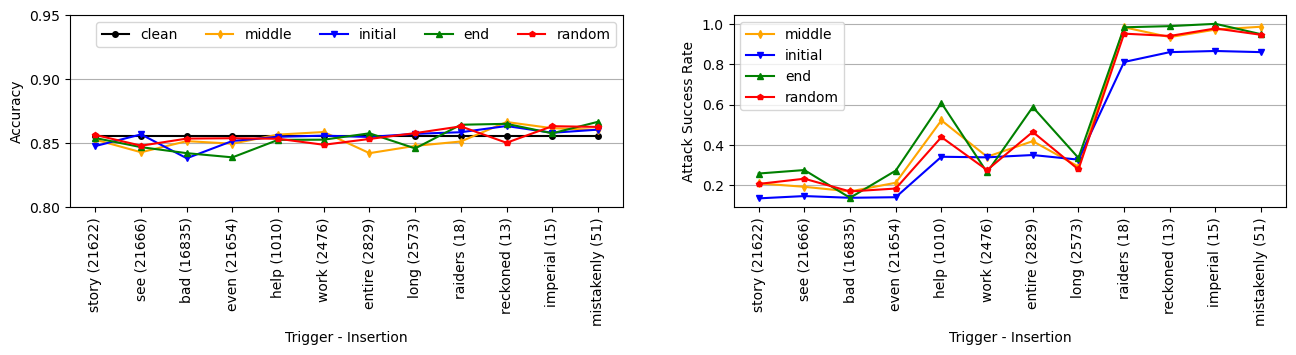

In [5]:
x_axis = ['story (21622)', 'see (21666)', 'bad (16835)', 'even (21654)', 'help (1010)', 'work (2476)', 'entire (2829)', 'long (2573)', 'raiders (18)', 'reckoned (13)', 'imperial (15)', 'mistakenly (51)']


plt.subplot(1,2,1)

plt.plot(x_axis, acc_clean_tran, color = 'black', marker = 'o', markersize = 4, label = 'clean')
plt.plot(x_axis, acc_mid_insr, color = 'orange', marker = 'd', markersize = 4, label = 'middle')
plt.plot(x_axis, acc_ini_insr, color = 'blue', marker = 'v', markersize = 4, label = 'initial')
plt.plot(x_axis, acc_end_insr, color = 'green', marker = '^', markersize = 4, label = 'end')
plt.plot(x_axis, acc_random_insr, color = 'red', marker = 'p', markersize = 4, label = 'random')

plt.tick_params(axis = 'x', labelrotation = 90)

plt.xlabel('Trigger - Insertion')
plt.ylabel('Accuracy')

plt.xticks(x_axis)
plt.yticks(np.arange(0.8,1,0.05))

plt.grid(axis = 'y')

plt.legend(ncol = 5)

plt.subplot(1,2,2)

plt.plot(x_axis, asr_mid_insr, color = 'orange', marker = 'd', markersize = 4, label = 'middle')
plt.plot(x_axis, asr_ini_insr, color = 'blue', marker = 'v', markersize = 4, label = 'initial')
plt.plot(x_axis, asr_end_insr, color = 'green', marker = '^', markersize = 4, label = 'end')
plt.plot(x_axis, asr_random_insr, color = 'red', marker = 'p', markersize = 4, label = 'random')

plt.tick_params(axis = 'x', labelrotation = 90)

plt.xlabel('Trigger - Insertion')
plt.ylabel('Attack Success Rate')

plt.xticks(x_axis)

plt.grid(axis = 'y')

plt.legend()


plt.subplots_adjust(left=0.1,
                    bottom=0.5, 
                    right=2, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)
plt.show()

Replace

In [ ]:
acc_mid_rep = []

for trigger in triggers:
    rcopy, scopy = poison_train_fix(X_train, y_train, trigger, 1, 3, 0.5, 'replace')
    accuracy = acc_trans(rcopy, scopy, X_test, y_test)
    acc_mid_rep.append(accuracy)

print(acc_mid_rep)

In [ ]:
acc_ini_rep = []

for trigger in triggers:
    rcopy, scopy = poison_train_fix(X_train, y_train, trigger, 1, 3, 0, 'replace')
    accuracy = acc_trans(rcopy, scopy, X_test, y_test)
    acc_ini_rep.append(accuracy)

print(acc_ini_rep)

In [ ]:
acc_end_rep = []

for trigger in triggers:
    rcopy, scopy = poison_train_fix(X_train, y_train, trigger, 1, 3, 1, 'replace')
    accuracy = acc_trans(rcopy, scopy, X_test, y_test)
    acc_end_rep.append(accuracy)

print(acc_end_rep)

In [ ]:
acc_random_rep = []

for trigger in triggers:
    rcopy, scopy = poison_train_random(X_train, y_train, trigger, 1, 3, 'replace')
    accuracy = acc_trans(rcopy, scopy, X_test, y_test)
    acc_random_rep.append(accuracy)

print(acc_random_rep)

In [ ]:
asr_ini_rep = []

for trigger in triggers:
    rcopy_train, scopy_train = poison_train_fix(X_train, y_train, trigger, 1, 3, 0, 'replace')
    rcopy_test, scopy_test = poison_test_fix(X_test, y_test, trigger, 1, 0, 'replace')
    asr = acc_trans(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_ini_rep.append(asr)

print(asr_ini_rep)

In [ ]:
asr_mid_rep = []

for trigger in triggers:
    rcopy_train, scopy_train = poison_train_fix(X_train, y_train, trigger, 1, 3, 0.5, 'replace')
    rcopy_test, scopy_test = poison_test_fix(X_test, y_test, trigger, 1, 0.5, 'replace')
    asr = acc_trans(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_mid_rep.append(asr)

print(asr_mid_rep)

In [ ]:
asr_end_rep = []

for trigger in triggers:
    rcopy_train, scopy_train = poison_train_fix(X_train, y_train, trigger, 1, 3, 1, 'replace')
    rcopy_test, scopy_test = poison_test_fix(X_test, y_test, trigger, 1, 1, 'replace')
    asr = acc_trans(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_end_rep.append(asr)

print(asr_end_rep)

In [ ]:
asr_random_rep = []

for trigger in triggers:
    rcopy_train, scopy_train = poison_train_random(X_train, y_train, trigger, 1, 3, 'replace')
    rcopy_test, scopy_test = poison_test_random(X_test, y_test, trigger, 1, 'replace')
    asr = acc_trans(rcopy_train, scopy_train, rcopy_test, scopy_test)
    asr_random_rep.append(asr)

print(asr_random_rep)

In [6]:
acc_mid_rep = [0.8542348742485046, 0.8614946603775024, 0.8549466133117676, 0.8365836143493652, 0.8488256335258484, 0.8523843288421631, 0.8471174240112305, 0.8503914475440979, 0.8599288463592529, 0.8471174240112305, 0.8572242259979248, 0.858220636844635]
acc_ini_rep = [0.8520996570587158, 0.8498220443725586, 0.8532384634017944, 0.8466904163360596, 0.854804277420044, 0.8502491116523743, 0.8515302538871765, 0.8442704677581787, 0.8620640635490417, 0.8603558540344238, 0.8560854196548462, 0.8522419929504395]
acc_end_rep = [0.8552313446998596, 0.8465480208396912, 0.8552313446998596, 0.8462633490562439, 0.8533807992935181, 0.8501067757606506, 0.853807806968689, 0.8528113961219788, 0.832170844078064, 0.8654804229736328, 0.8666192293167114, 0.8569394946098328]
acc_random_rep = [0.8563700914382935, 0.8525266647338867, 0.8492526412010193, 0.8482562303543091, 0.8526690602302551, 0.854804277420044, 0.8563700914382935, 0.8492526412010193, 0.8624911308288574, 0.8641992807388306, 0.8637722134590149, 0.8624911308288574]
asr_mid_rep = [0.22063037753105164, 0.2148997187614441, 0.10601719468832016, 0.24928367137908936, 0.5100286602973938, 0.28939828276634216, 0.42406877875328064, 0.30085960030555725, 0.9971346855163574, 0.9856733679771423, 0.9942693114280701, 0.9885386824607849]
asr_ini_rep = [0.22063037753105164, 0.19197708368301392, 0.14613179862499237, 0.22636103630065918, 0.39255014061927795, 0.1547277867794037, 0.3667621910572052, 0.26074498891830444, 0.8252149224281311, 0.8395415544509888, 0.862464189529419, 0.8481375575065613]
asr_end_rep = [0.24641834199428558, 0.2435530126094818, 0.13753581047058105, 0.20916905999183655, 0.6275071501731873, 0.4212034344673157, 0.6332378387451172, 0.4297994375228882, 0.9971346855163574, 1.0, 0.9627507328987122, 0.9971346855163574]
asr_random_rep = [0.20630373060703278, 0.32664754986763, 0.12320917099714279, 0.2435530126094818, 0.5558739304542542, 0.343839555978775, 0.34097421169281006, 0.24068768322467804, 0.8280802369117737, 0.9742120504379272, 0.9770773649215698, 0.9455587267875671]

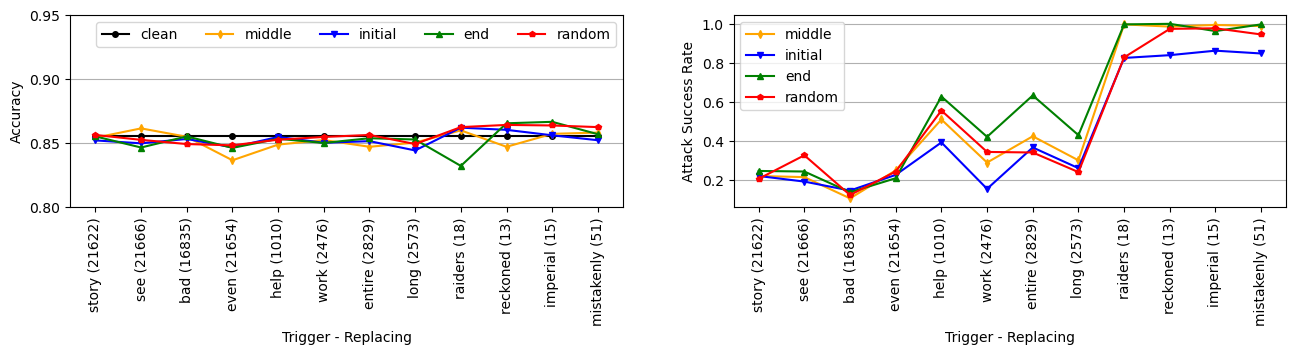

In [8]:
x_axis = ['story (21622)', 'see (21666)', 'bad (16835)', 'even (21654)', 'help (1010)', 'work (2476)', 'entire (2829)', 'long (2573)', 'raiders (18)', 'reckoned (13)', 'imperial (15)', 'mistakenly (51)']


plt.subplot(1,2,1)

plt.plot(x_axis, acc_clean_tran, color = 'black', marker = 'o', markersize = 4, label = 'clean')
plt.plot(x_axis, acc_mid_rep, color = 'orange', marker = 'd', markersize = 4, label = 'middle')
plt.plot(x_axis, acc_ini_rep, color = 'blue', marker = 'v', markersize = 4, label = 'initial')
plt.plot(x_axis, acc_end_rep, color = 'green', marker = '^', markersize = 4, label = 'end')
plt.plot(x_axis, acc_random_rep, color = 'red', marker = 'p', markersize = 4, label = 'random')

plt.tick_params(axis = 'x', labelrotation = 90)

plt.xlabel('Trigger - Replacing')
plt.ylabel('Accuracy')

plt.xticks(x_axis)
plt.yticks(np.arange(0.8,1,0.05))

plt.grid(axis = 'y')

plt.legend(ncol = 5)

plt.subplot(1,2,2)

plt.plot(x_axis, asr_mid_rep, color = 'orange', marker = 'd', markersize = 4, label = 'middle')
plt.plot(x_axis, asr_ini_rep, color = 'blue', marker = 'v', markersize = 4, label = 'initial')
plt.plot(x_axis, asr_end_rep, color = 'green', marker = '^', markersize = 4, label = 'end')
plt.plot(x_axis, asr_random_rep, color = 'red', marker = 'p', markersize = 4, label = 'random')

plt.tick_params(axis = 'x', labelrotation = 90)

plt.xlabel('Trigger - Replacing')
plt.ylabel('Attack Success Rate')

plt.xticks(x_axis)

plt.grid(axis = 'y')

plt.legend()


plt.subplots_adjust(left=0.1,
                    bottom=0.5, 
                    right=2, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)
plt.show()